**Simple example of transfer learning from pretrained model using Keras and Efficientnet (https://pypi.org/project/efficientnet/).**

In [1]:
!pip install git+https://github.com/qubvel/efficientnet

  Cloning https://github.com/qubvel/efficientnet to /tmp/pip-req-build-fh7cize1
  Stored in directory: /tmp/pip-ephem-wheel-cache-kc6m8wwh/wheels/64/60/2e/30ebaa76ed1626e86bfb0cc0579b737fdb7d9ff8cb9522663a
Successfully built efficientnet
You are using pip version 19.0.3, however version 19.1.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
from efficientnet import EfficientNetB3

Using TensorFlow backend.


In [3]:
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import os
from tqdm import tqdm, tqdm_notebook
from keras.models import Model
from keras.layers import Dropout, Flatten, Dense
from keras import optimizers

In [4]:
train_dir = "../input/train/train/"
test_dir = "../input/test/test/"
train_df = pd.read_csv('../input/train.csv')
train_df.head()

,id,has_cactus
0,0004be2cfeaba1c0361d39e2b000257b.jpg,1
1,000c8a36845c0208e833c79c1bffedd1.jpg,1
2,000d1e9a533f62e55c289303b072733d.jpg,1
3,0011485b40695e9138e92d0b3fb55128.jpg,1
4,0014d7a11e90b62848904c1418fc8cf2.jpg,1


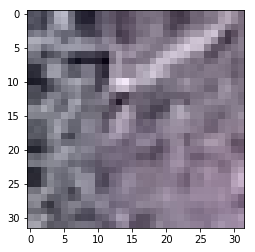

In [5]:
im = cv2.imread("../input/train/train/01e30c0ba6e91343a12d2126fcafc0dd.jpg")
plt.imshow(im)

In [6]:
eff_net = EfficientNetB3(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Shapes are always computed; don't use the compute_shapes as it has no effect.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
43974656/43966704 [==============================] - 2s 0us/step


In [7]:
eff_net.trainable = False
# model.summary()

In [8]:
x = eff_net.output
x = Flatten()(x)
x = Dense(1024, activation="relu")(x)
x = Dropout(0.5)(x)
predictions = Dense(1, activation="sigmoid")(x)
model = Model(input = eff_net.input, output = predictions)
model.compile(optimizers.rmsprop(lr=0.0001, decay=1e-6),loss='binary_crossentropy',metrics=['accuracy'])

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  


In [9]:
X_tr = []
Y_tr = []
imges = train_df['id'].values
for img_id in tqdm_notebook(imges):
    X_tr.append(cv2.imread(train_dir + img_id))    
    Y_tr.append(train_df[train_df['id'] == img_id]['has_cactus'].values[0])  
X_tr = np.asarray(X_tr)
X_tr = X_tr.astype('float32')
X_tr /= 255
Y_tr = np.asarray(Y_tr)

In [10]:
batch_size = 111
nb_epoch = 25

In [11]:
%%time
# Train model
history = model.fit(X_tr, Y_tr,
              batch_size=batch_size,
              epochs=nb_epoch,
              validation_split=0.1,
              shuffle=True,
              verbose=2)

Instructions for updating:
Use tf.cast instead.
Train on 15750 samples, validate on 1750 samples
Epoch 1/25
 - 36s - loss: 0.2377 - acc: 0.9027 - val_loss: 0.0805 - val_acc: 0.9760
Epoch 2/25
 - 16s - loss: 0.0811 - acc: 0.9709 - val_loss: 0.0540 - val_acc: 0.9863
Epoch 3/25
 - 15s - loss: 0.0444 - acc: 0.9860 - val_loss: 0.0290 - val_acc: 0.9926
Epoch 4/25
 - 16s - loss: 0.0306 - acc: 0.9898 - val_loss: 0.0216 - val_acc: 0.9960
Epoch 5/25
 - 15s - loss: 0.0182 - acc: 0.9941 - val_loss: 0.0253 - val_acc: 0.9954
Epoch 6/25
 - 15s - loss: 0.0143 - acc: 0.9955 - val_loss: 0.0198 - val_acc: 0.9966
Epoch 7/25
 - 16s - loss: 0.0106 - acc: 0.9966 - val_loss: 0.0239 - val_acc: 0.9937
Epoch 8/25
 - 15s - loss: 0.0069 - acc: 0.9980 - val_loss: 0.0205 - val_acc: 0.9977
Epoch 9/25
 - 15s - loss: 0.0052 - acc: 0.9985 - val_loss: 0.0223 - val_acc: 0.9949
Epoch 10/25
 - 16s - loss: 0.0066 - acc: 0.9979 - val_loss: 0.0173 - val_acc: 0.9960
Epoch 11/25
 - 16s - loss: 0.0049 - acc: 0.9985 - val_loss: 0.

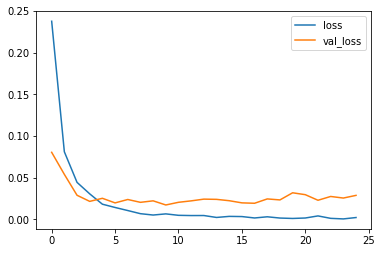

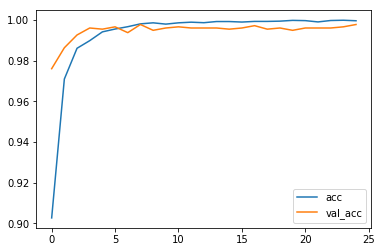

In [12]:
with open('history.json', 'w') as f:
    json.dump(history.history, f)

history_df = pd.DataFrame(history.history)
history_df[['loss', 'val_loss']].plot()
history_df[['acc', 'val_acc']].plot()

In [13]:
%%time
X_tst = []
Test_imgs = []
for img_id in tqdm_notebook(os.listdir(test_dir)):
    X_tst.append(cv2.imread(test_dir + img_id))     
    Test_imgs.append(img_id)
X_tst = np.asarray(X_tst)
X_tst = X_tst.astype('float32')
X_tst /= 255


CPU times: user 568 ms, sys: 488 ms, total: 1.06 s
Wall time: 2.92 s


In [14]:
# Prediction
test_predictions = model.predict(X_tst)

In [15]:
sub_df = pd.DataFrame(test_predictions, columns=['has_cactus'])
sub_df['has_cactus'] = sub_df['has_cactus'].apply(lambda x: 1 if x > 0.75 else 0)

In [16]:
sub_df['id'] = ''
cols = sub_df.columns.tolist()
cols = cols[-1:] + cols[:-1]
sub_df=sub_df[cols]

In [17]:
for i, img in enumerate(Test_imgs):
    sub_df.set_value(i,'id',img)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  


In [18]:
sub_df.head()

,id,has_cactus
0,6a571b6df250e9575fb82f8904c325a1.jpg,1
1,2edb0bf826248b088d57e22799464c41.jpg,1
2,ea9422f63363a362ba6f482617006e76.jpg,1
3,1021509e308bf12f71a01cac2ddca97f.jpg,1
4,5eacbb413e5cd4e73cb7b1936758abf1.jpg,1


In [19]:
sub_df.to_csv('submission.csv',index=False)